Code to compute analysis of COMPASS data used in the paper "Aggregating Measures of Accuracy and Fairness in Prediction Algorithms".

In [139]:
#@title Install mpltern for visualizations

!pip install mpltern

In [140]:
#@title Import packaages

import mpltern
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#@title Read COMPASS data into DataFrame
df = pd.read_csv('compas-scores-two-years.csv')

Downloading...
From: https://drive.google.com/uc?id=18XbOoXwXDtSsh4X7VsxWNoiiPkEjjZTu
To: /content/compas-scores-two-years.csv
100% 2.55M/2.55M [00:00<00:00, 113MB/s]


In [102]:
#@title Calculate Brier Score for COMPASS Algorithm
briers = []
for i,_ in df.iterrows():
  if df['decile_score'].iloc[i] == 0:
    score = .0001
  if df['decile_score'].iloc[i] == 10:
    score = .9999
  else:
    score = df['decile_score'].iloc[i]*.1
  actual = df['two_year_recid'].iloc[i]
  if actual == 0:
    briers.append(-((1-(1-score))**2 + score**2))
  else:
    briers.append(-((1-score)**2 + (1-score)**2))

brier_score = np.sum([(1/len(briers)) * b for b in briers])
print(f'Brier Accuracy Measure: {brier_score}')

Brier Accuracy Measure: -0.4589250357166621


In [103]:
#@title Calculate Logarithmic Score for COMPASS Algorithm

logs = []
for i,_ in df.iterrows():
  if df['decile_score'].iloc[i] == 0:
    score = .0001
  if df['decile_score'].iloc[i] == 10:
    score = .9999
  else:
    score = df['decile_score'].iloc[i]*.1
  actual = df['two_year_recid'].iloc[i]
  if actual == 0:
    logs.append(np.log(1-score))
  else:
    logs.append(np.log(score))

log_score = np.sum([(1/len(logs)) * l for l in logs])
print(f'Logarithmic Accuracy Measure: {log_score}')

Logarithmic Accuracy Measure: -0.739905379117709


In [180]:
#@title Calculate Equal Opportunity Score for COMPASS Algorithm

black_positives = []
black_positive_predictions = []
for i,_ in df.iterrows():
  if df['race'].iloc[i] == 'African-American':
    if df['two_year_recid'].iloc[i] == 0:
      black_positives.append(i)
      if df['decile_score'].iloc[i] == 0:
        score = .0001
      if df['decile_score'].iloc[i] == 10:
        score = .9999
      else:
        score = df['decile_score'].iloc[i]*.1
      black_positive_predictions.append(score)


non_black_positives = []
non_black_positive_predictions = []
for i,_ in df.iterrows():
  if df['race'].iloc[i] != 'African-American':
    if df['two_year_recid'].iloc[i] == 0:
      non_black_positives.append(i)
      if df['decile_score'].iloc[i] == 0:
        score = .0001
      if df['decile_score'].iloc[i] == 10:
        score = .9999
      else:
        score = df['decile_score'].iloc[i]*.1
      non_black_positive_predictions.append(score)

eq_opp_score = -np.abs(np.mean(black_positive_predictions)
                   - np.mean(non_black_positive_predictions))
print(f'Black False Negative Rate: {np.mean(black_positive_predictions)}')
print(f'Non-Black False Negative Rate: {np.mean(non_black_positive_predictions)}')
print(f'Equal Opportunity Fairness Measure: {eq_opp_score}')

Black False Negative Rate: 0.43960674094707525
Non-Black False Negative Rate: 0.294509778597786
Equal Opportunity Fairness Measure: -0.14509696234928926


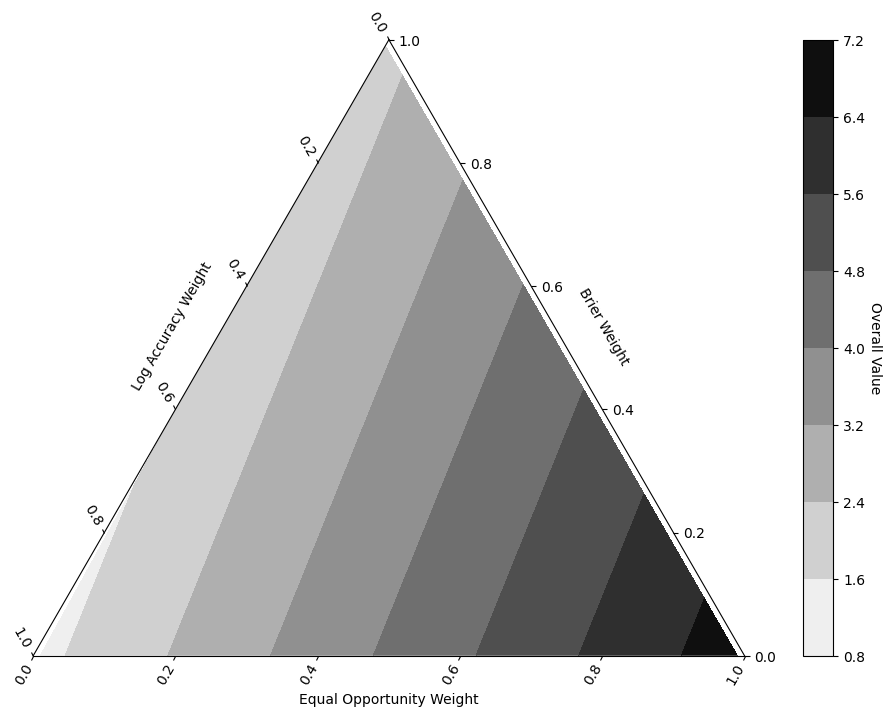

In [175]:
#@title Generate Figure 1

def y_definer(x):
    return np.array([y for y in np.arange(.01,1-x,.01)])
def z_definer(x,y):
    return np.array([1-(x+y)])
brier_weights = []
log_weights = []
eq_opp_weights = []
for x in np.arange(0,1.01,.01):
    for y in y_definer(x):
        for z in z_definer(x,y):
            brier_weights.append(x)
            log_weights.append(y)
            eq_opp_weights.append(z)

overalls = [brier_weight*np.abs(brier_score)**-1
            + log_weight*np.abs(log_score)**-1
            + eq_opp_weight*np.abs(eq_opp_score)**-1
              for brier_weight,log_weight,eq_opp_weight
                        in zip(brier_weights,log_weights,eq_opp_weights)]

plt.figure(figsize=(15, 8))
ax = plt.subplot(projection="ternary")
cs = ax.tricontourf(brier_weights, log_weights,
                                eq_opp_weights, overalls, cmap="binary")

ax.set_tlabel('Brier Weight')
ax.set_llabel('Log Accuracy Weight')
ax.set_rlabel('Equal Opportunity Weight')
ax.taxis.set_label_position("tick1")
ax.laxis.set_label_position("tick1")
ax.raxis.set_label_position("tick1")
colorbar = plt.colorbar(cs)
colorbar.set_label('Overall Value', rotation=270, va='baseline')

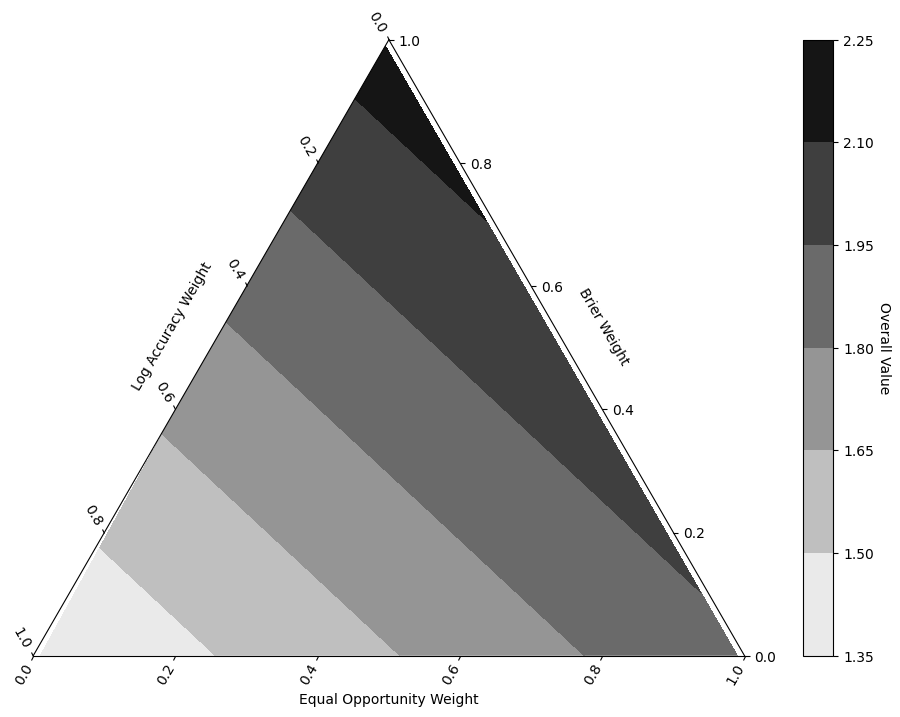

In [177]:
#@title Generate Figure 2

def y_definer(x):
    return np.array([y for y in np.arange(.01,1-x,.01)])
def z_definer(x,y):
    return np.array([1-(x+y)])
brier_weights = []
log_weights = []
eq_opp_weights = []
for x in np.arange(0,1.01,.01):
    for y in y_definer(x):
        for z in z_definer(x,y):
            brier_weights.append(x)
            log_weights.append(y)
            eq_opp_weights.append(z)

overalls = [brier_weight*np.abs(brier_score)**-1
            + log_weight*np.abs(log_score)**-1
            + eq_opp_weight*np.log(np.abs(eq_opp_score)**-1)
              for brier_weight,log_weight,eq_opp_weight
                        in zip(brier_weights,log_weights,eq_opp_weights)]

plt.figure(figsize=(15, 8))
ax = plt.subplot(projection="ternary")
cs = ax.tricontourf(brier_weights, log_weights,
                                eq_opp_weights, overalls, cmap="binary")

ax.set_tlabel('Brier Weight')
ax.set_llabel('Log Accuracy Weight')
ax.set_rlabel('Equal Opportunity Weight')
ax.taxis.set_label_position("tick1")
ax.laxis.set_label_position("tick1")
ax.raxis.set_label_position("tick1")
colorbar = plt.colorbar(cs)
colorbar.set_label('Overall Value', rotation=270, va='baseline')

In [178]:
len(df)

7214